In [463]:
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf

replace THSarabunChula-Regular.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [464]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
font = {'family' : 'TH Sarabun Chula',
        'weight' : 'bold',
        'size'   : 15}
mpl.rc('font',  **font)

# **import ข้อมูล**

In [465]:
aluminumFilesURL = ['https://raw.githubusercontent.com/NattapongKong/TensileLab/main/0928AL6063-0.txt'
                    ,'https://raw.githubusercontent.com/NattapongKong/TensileLab/main/0928AL6063-1.txt'
                    ,'https://raw.githubusercontent.com/NattapongKong/TensileLab/main/921al2.txt']
steelFileURL = ['https://raw.githubusercontent.com/NattapongKong/TensileLab/main/0928sr24.txt']
alDf = []
stDf = []
alReportArray = pd.DataFrame({})
stReportArray = pd.DataFrame({})
columnHeader = ['Time (s)', 'Strain', 'Stress (Pa)', 'Dispacement (cm)', 'Load (N)', 'Voltage Displacement', 'Voltage Load']
try:
  for file in aluminumFilesURL:
    fileDf = pd.read_csv(file, delimiter='\t',names=columnHeader)
    alDf.append(fileDf)
  for file in steelFileURL:
    fileDf = pd.read_csv(file, delimiter='\t',names=columnHeader)
    stDf.append(fileDf)
except Exception:
  raise Exception('file Error')

# **ทำ Filter**

In [466]:
def Curve_filter(Df,name):
    returnArray = []
    i = 0
    for df in Df:
      stress = df['Stress (Pa)'].values
      strain = df['Strain'].values
      strain_filtered = np.array(savgol_filter(strain,2000,4)) #ทำ Strain Filter ด้วยวิธี Savitzky–Golay filter gate
      stress_filtered = np.array(savgol_filter(stress,1000,4)) #ทำ Stress Filter ด้วยวิธี Savitzky–Golay filter gate
      rangeFilter = (strain_filtered>0.0) & (strain_filtered<0.43) #ช่วง strain ที่ใช้ทำ filter

      #Plot Graph
      plt.figure(figsize=(10, 5)) # windown size
      plt.plot(strain[rangeFilter],stress[rangeFilter],label='Stress-Strain before Filter')
      plt.plot(strain_filtered[rangeFilter],stress_filtered[rangeFilter],label='Stress-Strain after Filter')
      plt.grid()
      plt.legend(loc='lower right')
      plt.xlabel("Strain")
      plt.ylabel("Stress (x10^8 Pa)")
      plt.title(str(name)+' Stress-Strain Curve (' + str(i+1) +')')
      plt.show()
      returnArray.append([strain_filtered,stress_filtered])
      i = i+1
      print('')
    return returnArray


# **หา Yield Point**

In [467]:
def interpolated_intercept(x, y1, y2): #ฟังค์ชั่นที่ใช้ในการหาจุด intercept ของ datapoints วิธี nearest datapoint and interpolation (Math ล้วนๆ) เอาเป็นว่าใส่ x y 2 curve ฟังค์ชั่นจะให้ค่าจุดตัดละกัน
    def intercept(point1, point2, point3, point4): #คำนวณจุด intercept
        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C
        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]
            x = Dx / D
            y = Dy / D
            return x,y
        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])
        R = intersection(L1, L2)
        return R
    idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
    xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))
    return xc,yc

In [468]:
def find_yield(df,name,n_Seg = 4): #หาค่า yield
  i = 0
  yieldPoint = []
  youngArray = []
  tensileArray = []
  for data in df:
    #ประกาศตัวแปร
    x = data[0]
    y = data[1]
    xs = x.reshape(-1,1)
    ys = y.reshape(-1,1)

    dys = np.gradient(y, x).reshape(-1,1) #หาค่า Gradient
    rgr = DecisionTreeRegressor(max_leaf_nodes=n_Seg) #ประกาศ Decision Tree สำหรับการหา Segmented Regression
    rgr.fit(xs,dys) #fit curve
    dys_dt = rgr.predict(xs).flatten() #return ค่าความชันคงที่ในช่วงต่างๆของกราฟ
    y_sl = np.ones(len(xs)) * np.nan
    msk = np.array(dys_dt) == np.max(np.unique(dys_dt)) #ใช้ค่า gradient ที่สูงสุด (ใช้ประโยชน์จากช่วง Elastic จะมีความชันมากสุดในกราฟ)
    msk_start = next((i for i, x in enumerate(msk) if x), None) #หาจุดเริ่มของช่วง Elastic ที่ใช้
    lin_reg = LinearRegression() #ประกาศวิธีการว่าเราจะใช้วิธี Linear Regression นะ
    lin_reg.fit(x[msk].reshape(-1,1),y[msk].reshape(-1,1)) #ทำการ fitcurve
    slope = lin_reg.coef_[0] #ได้ค่าความชันกราฟเส้นตรง
    intercept = lin_reg.intercept_ #ค่า c
    y_reg_lin_offseted = slope * (x - (0.2/100)) + intercept #**สร้างสมการเส้นตรง โดย x จะขยับ 0.2% offset
    xIntercept,yIntercept = interpolated_intercept(x,y_reg_lin_offseted,y) #.หาค่า intercept

    #plot Graph เปลี่ยนได้ตามใจชอบ
    lin_msk = (x>=x[msk_start]) & (x<=(xIntercept[0][0] + 0.001)) #หาช่วงพล็อตกราฟ
    plt.figure(figsize=(10, 5)) #size
    plt.plot(x[lin_msk],y_reg_lin_offseted[lin_msk],label='Linear Regression Within Elastic Range',zorder=0)
    plt.plot(x,y,label='Filtered Stress-Strain Curve',zorder=1)
    plt.scatter(xIntercept,yIntercept,color='r',label='Yield Point',zorder=2)
    plt.scatter(x[y==np.max(y)],y[y==np.max(y)],label='Ultimate Tensie Strength',marker='^',zorder=3)
    plt.grid() #ตาราง
    plt.legend(loc='lower right')
    plt.xlabel("Strain")
    plt.ylabel("Stress (Pa)")
    plt.title(str(name)+' Stress-Strain Curve (' + str(i+1) +')')
    plt.show()
    i=i+1
    #output
    print('yield point: ' + str(yIntercept[0][0]) + 'Pa')
    print('young Modulus: ' + str(slope[0]) + ' Pa')
    print('Ultimate Tensie Strength: ' + str(np.max(y)) + ' Pa')
    yieldPoint.append(yIntercept[0][0])
    youngArray.append(slope[0])
    tensileArray.append(np.max(y))
  #เขียนข้อมูลลงตาราง
  df = pd.DataFrame({})
  df['yield point (Pa)'] = yieldPoint
  df['young Modulus(Pa)'] = youngArray
  df['Ultimate Tensie Strength (Pa)'] = tensileArray
  return df



# Aluminum **6063-T5**

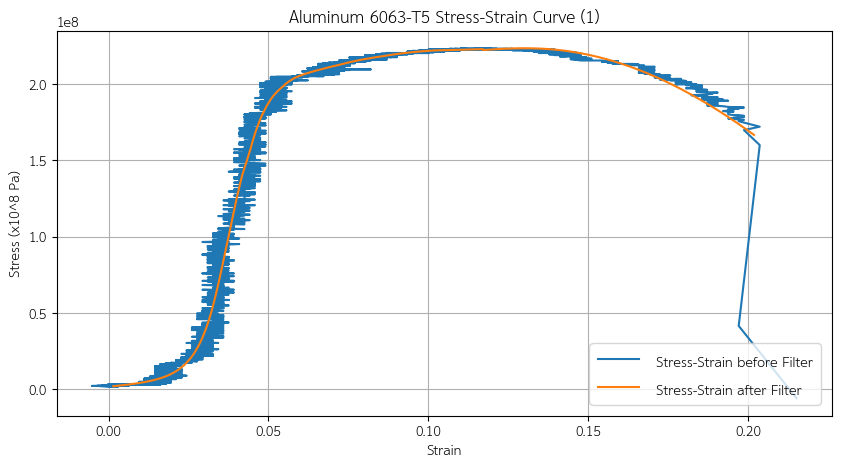

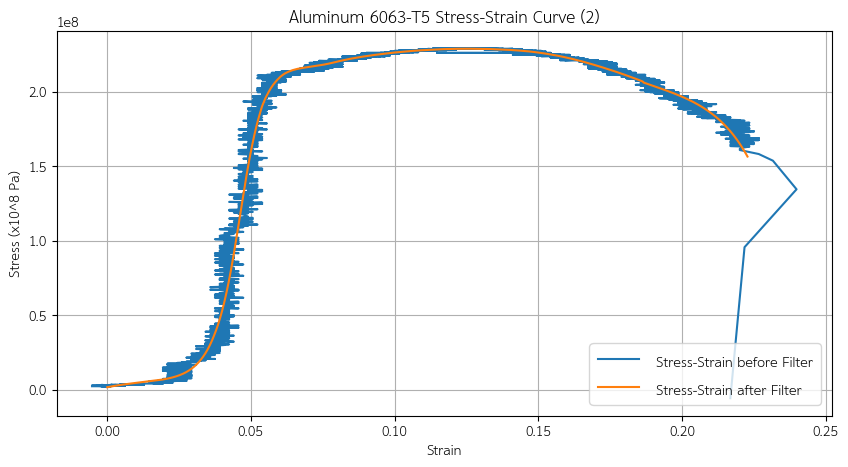

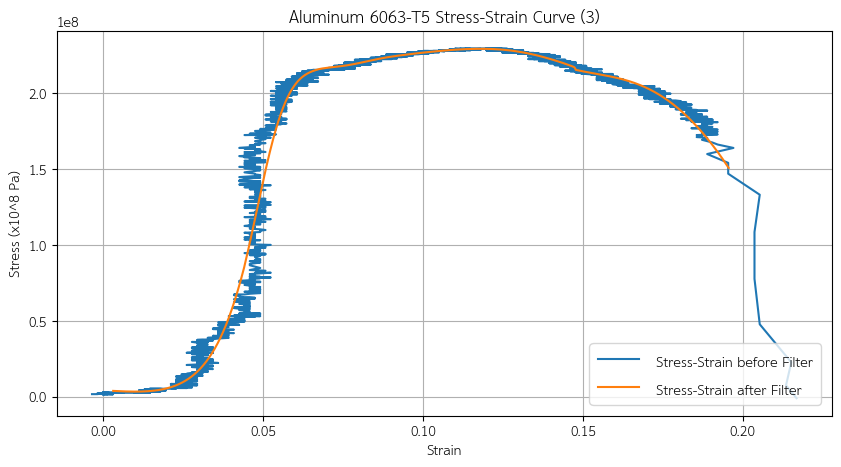

In [469]:
x = Curve_filter(alDf,'Aluminum 6063-T5')

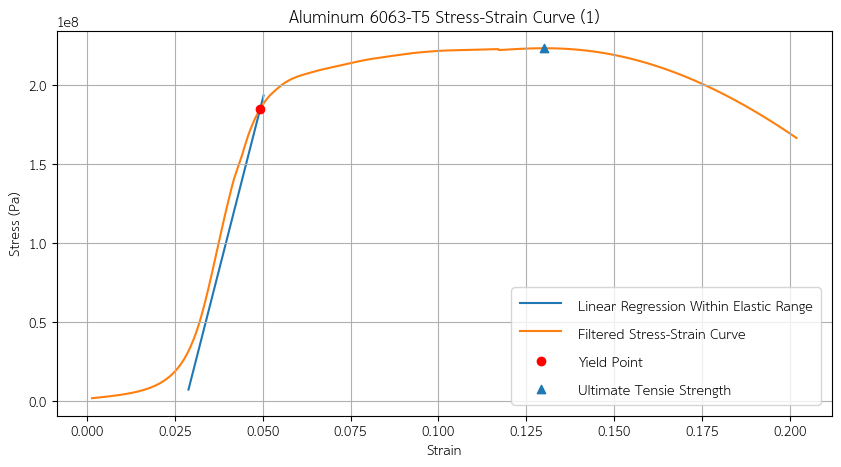

yield point: 185080453.42740825Pa
young Modulus: 8707857910.906292 Pa
Ultimate Tensie Strength: 223413880.95931894 Pa


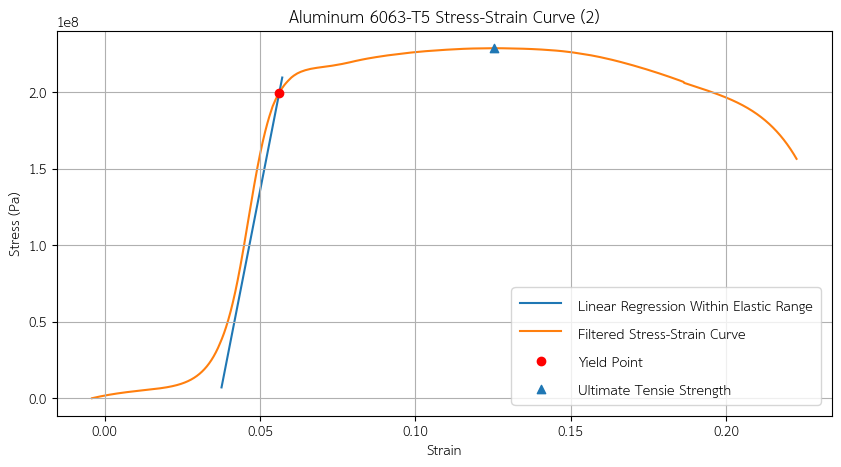

yield point: 199790203.5128001Pa
young Modulus: 10374780824.60006 Pa
Ultimate Tensie Strength: 228893124.5857014 Pa


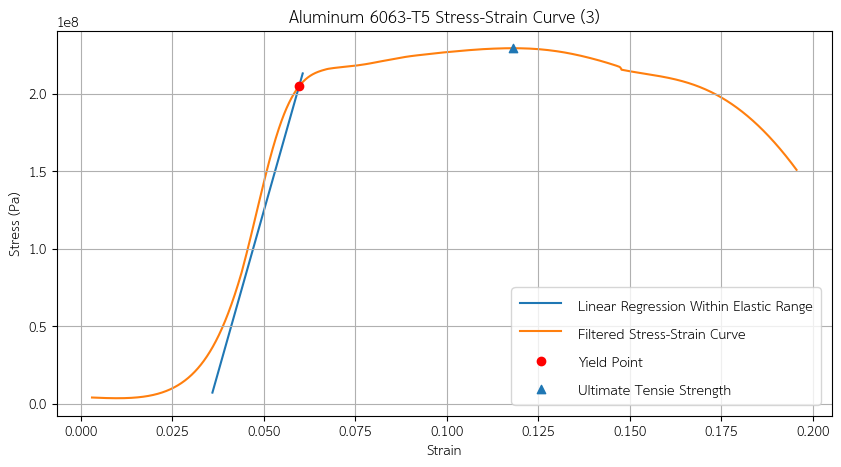

yield point: 204756357.9962653Pa
young Modulus: 8348307772.310188 Pa
Ultimate Tensie Strength: 229283773.03351372 Pa


,yield point (Pa),young Modulus(Pa),Ultimate Tensie Strength (Pa)
0,1.850805e+08,8.707858e+09,2.234139e+08
1,1.997902e+08,1.037478e+10,2.288931e+08
2,2.047564e+08,8.348308e+09,2.292838e+08


In [470]:
find_yield(x,'Aluminum 6063-T5', 4)

# **SR24**



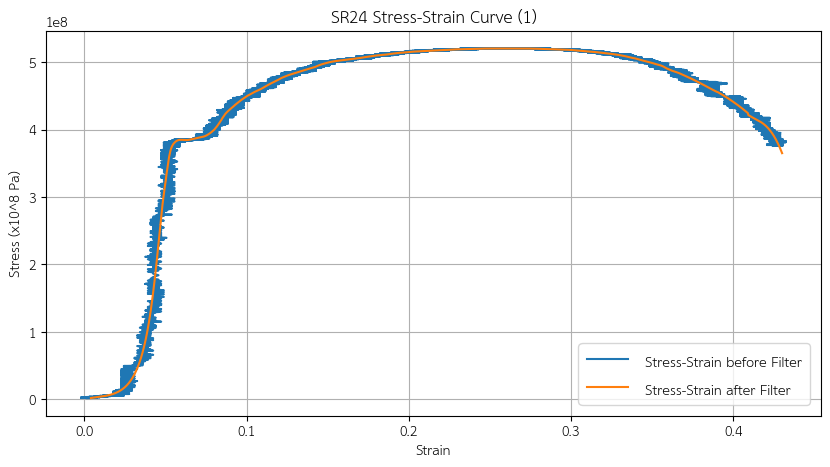

In [471]:
x = Curve_filter(stDf,'SR24')

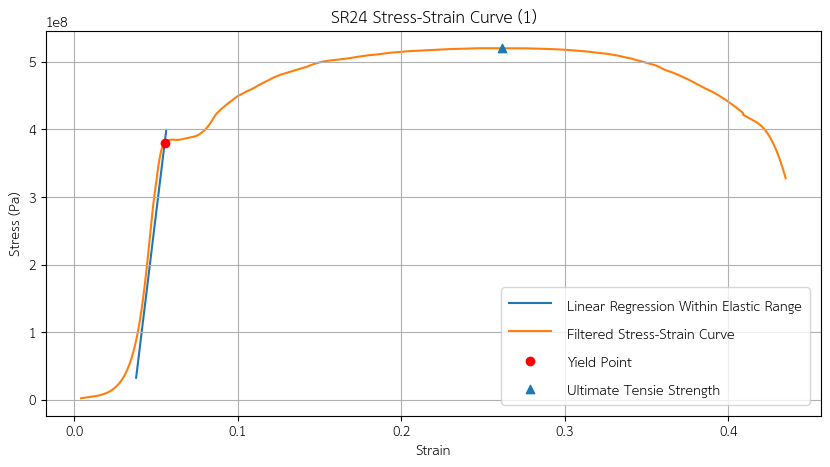

yield point: 379542552.56778795Pa
young Modulus: 19907993274.67202 Pa
Ultimate Tensie Strength: 520142709.1326762 Pa


,yield point (Pa),young Modulus(Pa),Ultimate Tensie Strength (Pa)
0,3.795426e+08,1.990799e+10,5.201427e+08


In [472]:
find_yield(x,'SR24', 4)